# City_of_London Housing Price Prediction 


This notebook demonstrates a complete workflow for predicting housing prices in London
using Random Forest Regression. We clean and preprocess the data, detect and remove outliers,
select relevant features, train a model, evaluate its performance, and visualize the results.


# 1. Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  # Split data into training and test sets
from sklearn.preprocessing import OneHotEncoder       # Encode categorical variables numerically
from sklearn.compose import ColumnTransformer         # Apply transformations to specific columns
from sklearn.pipeline import Pipeline                 # Chain multiple processing steps together
from sklearn.impute import SimpleImputer              # Handle missing data by filling in values
from sklearn.ensemble import RandomForestRegressor    # Random forest algorithm for regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Evaluate model performance

# 2. Load Dataset

In [2]:
df = pd.read_csv("City_of_London_link_26122024.csv")
df.head()

,priceper,year,dateoftransfer,propertytype,duration,price,postcode,lad23cd,transactionid,lmk_key,tfarea,numberrooms,classt,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,CONSTRUCTION_AGE_BAND
0,4351.648352,2002,2002-12-06,F,L,198000,E1 8RB,E09000001,{6C4E5F5C-3C58-446D-8676-C3CDD961CAB8},542072661032010091822445956968803,45.50,2.0,11,84,88,England and Wales: 1983-1990
1,3619.588361,2000,2000-03-08,F,L,153000,EC4V 3PL,E09000001,{D4886E7B-0F98-4255-93F5-42946A43D503},526623989342010081222564479809228,42.27,2.0,12,83,84,England and Wales: 1996-2002
2,5441.211261,2002,2002-09-26,F,L,230000,EC4V 3PL,E09000001,{25475B09-53BE-4738-AD78-22315C76E705},526623989342010081222564479809228,42.27,2.0,12,83,84,England and Wales: 1996-2002
3,11462.765957,2014,2014-05-27,F,L,1077500,EC1A 7HN,E09000001,{5F107CC0-E753-41BE-8747-41680C2642C9},878247563352013013119282897770104,94.00,3.0,12,80,83,England and Wales: 1950-1966
4,3170.212766,1999,1999-04-23,F,L,298000,EC1A 7HN,E09000001,{527813A5-9E07-406A-9F17-7F5A9C83B9A4},878247563352013013119282897770104,94.00,3.0,12,80,83,England and Wales: 1950-1966


# 3. Visualize Price Distribution

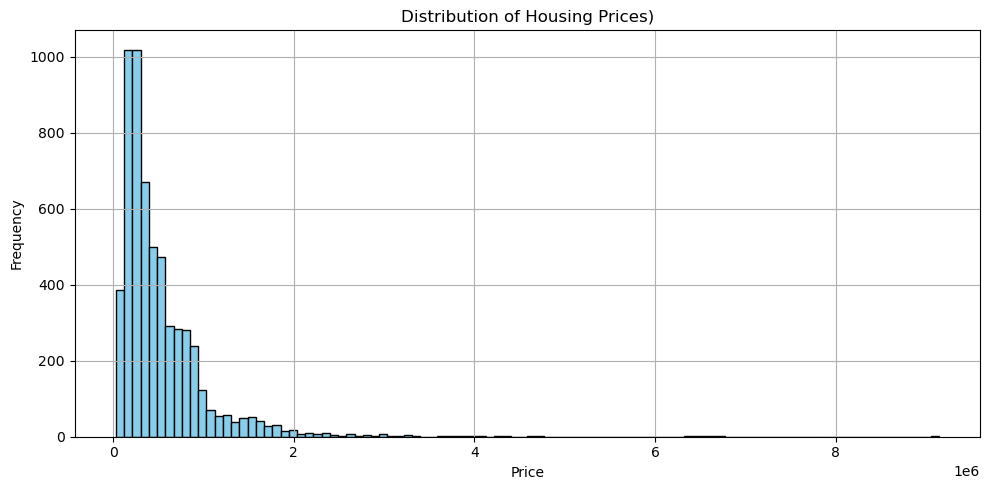

In [3]:
plt.figure(figsize=(10, 5))
plt.hist(df['price'], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of Housing Prices)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### Explanation:
We use a histogram to visualize the distribution of housing prices. This helps us identify extremely high or low values (outliers) that may bias the model.

The plot shows a right-skewed distribution with a cluster of properties priced below ₺1,500,000 and a long tail extending into very high prices.
This confirms the presence of high-value outliers.


# 4. Outlier Detection and Removal using IQR (Interquartile Range)


In [4]:
# Compute IQR boundaries
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [5]:
# Filter out outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

In [6]:
# Check shape after removal
after_shape = df.shape
print("Shape after outlier removal:", after_shape)

Shape after outlier removal: (5489, 16)


#### Explanation:
We use the Interquartile Range (IQR) method to remove outliers in the price column.
This keeps the values within 1.5 times the IQR from the first and third quartiles.

The dataset reduced from {initial_shape[0]} rows to {after_shape[0]} rows, meaning {initial_shape[0] - after_shape[0]} rows were removed.
Most of these were very high-priced properties, which tend to distort the learning process. The remaining data better represents typical housing prices.

# Step 5: Define Features and Target Variable


In [7]:
# Define target and input features
target = 'price'
features = [
    'numberrooms',
    'tfarea',
    'propertytype',
    'duration',
    'CONSTRUCTION_AGE_BAND',
    'CURRENT_ENERGY_EFFICIENCY',
    'POTENTIAL_ENERGY_EFFICIENCY'
]
X = df[features]
y = df[target]

#### Explanation:
We set price as the target variable to be predicted. The selected features describe the structural and energy characteristics of each property.

7 relevant features were selected for modeling.
All are expected to have a potential influence on price — and none are IDs or non-informative variables.

# Step 6: Data Preprocessing (Imputation & Encoding)


In [8]:
# Identify numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [9]:
# Define transformers
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [10]:
# Numerical: fill missing values with mean
numeric_transformer = SimpleImputer(strategy='mean')

In [11]:
# Categorical: fill missing with most frequent + encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#### Explanation:
We separate the input features into numerical and categorical columns.
Then we build a preprocessing pipeline that:

* Fills missing numeric values with the mean

* Fills missing categorical values with the most frequent category

* Applies OneHotEncoding to convert categories into usable numeric features

Missing values (like in numberrooms, CONSTRUCTION_AGE_BAND) will be handled automatically.
Categorical features like propertytype and duration will be turned into binary indicators, making them usable by machine learning algorithms.

# Step 7: Split Data into Training and Test Sets


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (4391, 7)
Test set size: (1098, 7)


#### Explanation:
We split the data into training (80%) and testing (20%) sets.
This allows the model to learn from one part of the data and be evaluated on unseen data.

The model will be evaluated fairly on data it has not seen during training.
The split was done randomly but reproducibly thanks to random_state=42.

# Step 8: Train Random Forest Model with Pipeline


In [14]:
# Build pipeline: preprocessing + model
rf_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [15]:
# Fit the model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['numberrooms', 'tfarea',
                                                   'CURRENT_ENERGY_EFFICIENCY',
                                                   'POTENTIAL_ENERGY_EFFICIENCY']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['propertytype', 'duration',
                                                   'CONSTRUCTION_AGE_BAND'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

#### Explanation:
We create a full pipeline that includes both preprocessing and model training.
The RandomForestRegressor is an ensemble model made up of multiple decision trees — robust and effective even when data has non-linear relationships.

The model has now learned from the training data, with all preprocessing steps handled inside the pipeline.
It’s now ready to make predictions and be evaluated.

# Step 9: Make Predictions and Evaluate Model


In [16]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [17]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


In [18]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 175181.02
RMSE: 231222.11
R² Score: 0.3203


#### Explanation:
We use the trained model to make predictions on the test set and evaluate it using:

* MAE (Mean Absolute Error): Average prediction error

* RMSE (Root Mean Squared Error): Penalizes larger errors more

* R² Score: How much of the price variation is explained by the model

-------

* MAE: ₺175,181 → On average, the model's predictions are off by around ₺175K.

* RMSE: ₺231,222 → Larger errors are still present but less extreme due to earlier outlier removal.

* R² Score: 0.3203 → The model explains 32% of the variation in housing prices.

 While this R² value is moderate, it reflects that price alone cannot be fully predicted by structural features like room count or floor area. Other important features such as location (e.g. postcode, neighborhood quality) are not yet included and could significantly improve model performance.

# Step 10: Visualize Actual vs Predicted Prices

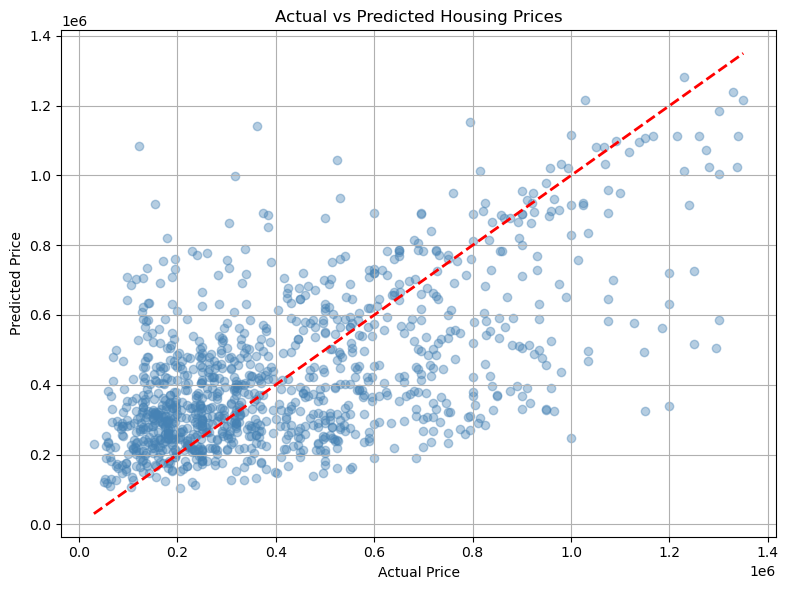

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Housing Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Explanation:
This scatter plot compares actual housing prices to the model’s predicted prices. The red dashed line shows where perfect predictions would fall.

##### Result:

* While there's a general upward trend, many predictions fall below the red line, especially at higher price ranges — meaning the model underestimates expensive properties.

* The predictions are more concentrated and consistent in the low to mid-price range, but less accurate for houses above ₺700,000.

* This visual pattern matches the R² score of 0.32, showing that there's still a large portion of price variability the model cannot explain.

##### Conclusion:

To improve prediction accuracy, especially for high-priced properties, we may need to:

* Incorporate location-based features (like postcode, lad23cd)

* Engineer more meaningful variables (e.g., price per m², building age)

* Experiment with advanced models (e.g., XGBoost, Gradient Boosting)